In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras

from imblearn.over_sampling import SMOTE
from collections import Counter


In [2]:
yelp_df = pd.read_csv("../Resources/cleaned_data2.csv")

yelp_df.head()

,id,name,image_url,is_closed,url,review_count,rating,transactions,price,group_city,cuisines,latitude,longitude,state
0,a0IET3_yCFcO36OqGSsisg,Eataly NYC Flatiron,https://s3-media4.fl.yelpcdn.com/bphoto/1UDlnu...,False,https://www.yelp.com/biz/eataly-nyc-flatiron-n...,6102,4.0,"delivery, pickup",2,New York City,Italian,40.742101,-73.989922,NY
1,zj8Lq1T8KIC5zwFief15jg,Prince Street Pizza,https://s3-media4.fl.yelpcdn.com/bphoto/PfI8oV...,False,https://www.yelp.com/biz/prince-street-pizza-n...,5031,4.5,"delivery, pickup",1,New York City,Italian,40.723088,-73.994530,NY
2,16ZnHpuaaBt92XWeJHCC5A,Olio e Più,https://s3-media4.fl.yelpcdn.com/bphoto/CUpPgz...,False,https://www.yelp.com/biz/olio-e-pi%C3%B9-new-y...,4858,4.5,"delivery, pickup",2,New York City,Italian,40.733798,-73.999774,NY
3,vyoA8dxwScuMV_AsTcjQcg,L & B Spumoni Gardens,https://s3-media1.fl.yelpcdn.com/bphoto/hN5xKw...,False,https://www.yelp.com/biz/l-and-b-spumoni-garde...,4647,4.0,"delivery, pickup",2,New York City,Italian,40.594715,-73.981316,NY
4,22nKUyCIbpnzR6R3_g1ptQ,Carmine's Italian Restaurant - Times Square,https://s3-media1.fl.yelpcdn.com/bphoto/0UszeE...,False,https://www.yelp.com/biz/carmines-italian-rest...,4644,4.0,"delivery, pickup",2,New York City,Italian,40.757498,-73.986653,NY


In [3]:
# Create new columns and check if 'delivery', 'pickup', or 'restaurant_reservation' is in 'transactions'
yelp_df['delivery'] = yelp_df['transactions'].str.contains('delivery', case=False, na=False)
yelp_df['pickup'] = yelp_df['transactions'].str.contains('pickup', case=False, na=False)
yelp_df['restaurant_reservation'] = yelp_df['transactions'].str.contains('restaurant_reservation', case=False, na=False)

# Fill NaN values with False in the new columns
yelp_df['delivery'] = yelp_df['delivery'].fillna(False)
yelp_df['pickup'] = yelp_df['pickup'].fillna(False)
yelp_df['restaurant_reservation'] = yelp_df['restaurant_reservation'].fillna(False)

In [4]:
yelp_df.drop(columns='transactions', inplace= True)

yelp_df.dropna(inplace=True)

In [5]:
# Define a function to determine 'success'
def is_success(rating):
    return rating > 3.7

# Create a new 'success' column based on the 'rating' column
yelp_df['success'] = yelp_df['rating'].apply(is_success)

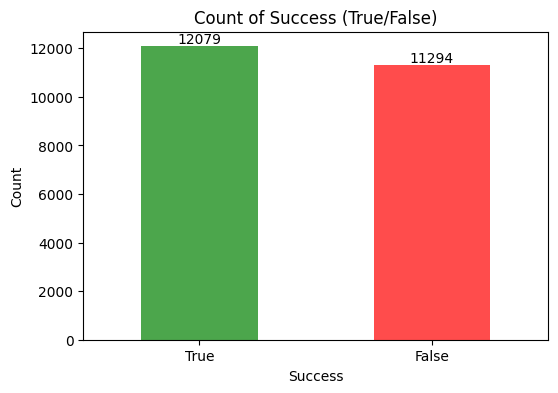

In [6]:
# Count the values in the 'success' column
success_counts = yelp_df['success'].value_counts()

# Create a bar chart
plt.figure(figsize=(6, 4))
success_counts.plot(kind='bar', color=['green', 'red'], alpha=0.7)
plt.title('Count of Success (True/False)')
plt.xlabel('Success')
plt.ylabel('Count')

# Annotate the bars with counts
for index, value in enumerate(success_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.xticks(rotation=0)
plt.show()

In [7]:
# Set features
y = yelp_df['success']
X = yelp_df.drop(columns=['success','rating'])


<ipython-input-8-8b1c33342ed7>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = X.corr()


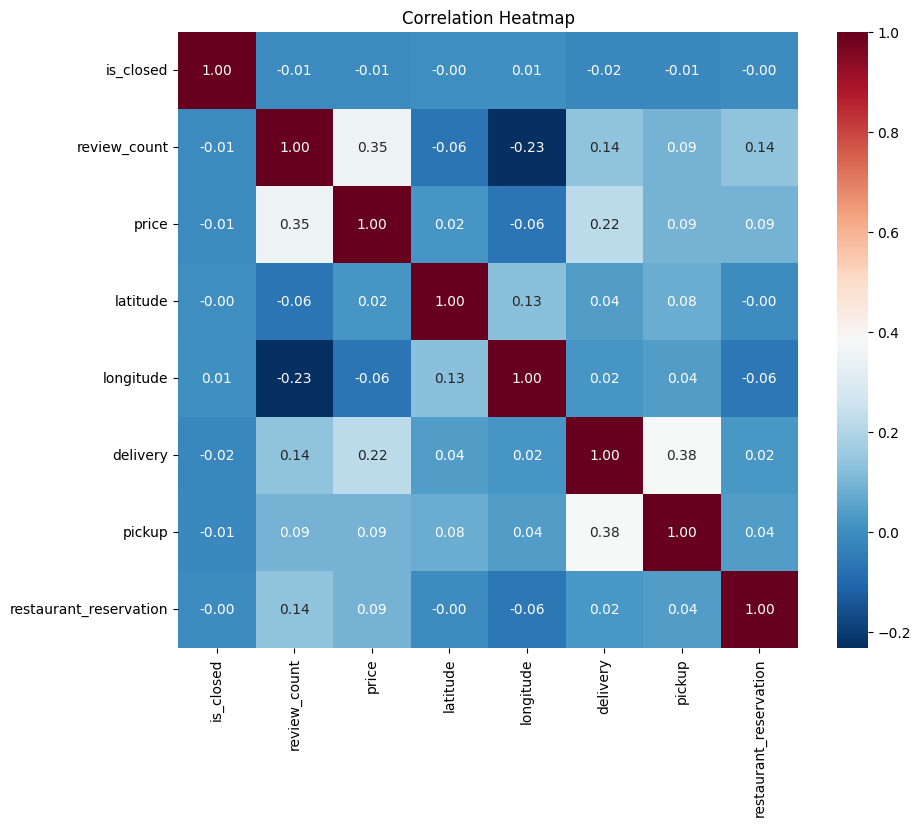

In [8]:
# Generate a correlation matrix for your features (X)
correlation_matrix = X.corr()

# Create a heatmap with correlation values
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [9]:
# Look at NAME value counts for binning
name_count = X['name'].value_counts()
name_count

Taco Bell                          956
Chipotle Mexican Grill             766
Chili's                            295
Olive Garden Italian Restaurant    249
QDOBA Mexican Eats                 173
                                  ... 
Kinsey's Italian Cafe                1
Tex-Mex                              1
EL Azabache Mexican Restaurant       1
Pasto Italiano                       1
Mexitaco Kitchen                     1
Name: name, Length: 15173, dtype: int64

In [10]:
# Choose a cutoff value and create a list of name to be replaced
# use the variable name `name_to_replace`
name_to_replace = list(name_count[name_count<5].index)


# Replace in dataframe
for app in name_to_replace:
    X['name'] = X['name'].replace(app,"Other")

# Check to make sure binning was successful
X['name'].value_counts()

Other                              17696
Taco Bell                            956
Chipotle Mexican Grill               766
Chili's                              295
Olive Garden Italian Restaurant      249
                                   ...  
Kalaveras                              5
Los Amigos                             5
Taco Bamba                             5
Rio Mambo                              5
Zeppe's Pizzeria                       5
Name: name, Length: 294, dtype: int64

In [11]:
X = pd.get_dummies(X, columns=['name','state','group_city'], dtype=float)
X.head()

,id,image_url,is_closed,url,review_count,price,cuisines,latitude,longitude,delivery,...,group_city_Sacramento,group_city_San Antonio,group_city_San Diego,group_city_San Francisco,group_city_San Jose,group_city_Seattle,group_city_Tucson,group_city_Virginia Beach,"group_city_Washington, D.C.",group_city_Wichita
0,a0IET3_yCFcO36OqGSsisg,https://s3-media4.fl.yelpcdn.com/bphoto/1UDlnu...,False,https://www.yelp.com/biz/eataly-nyc-flatiron-n...,6102,2,Italian,40.742101,-73.989922,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,zj8Lq1T8KIC5zwFief15jg,https://s3-media4.fl.yelpcdn.com/bphoto/PfI8oV...,False,https://www.yelp.com/biz/prince-street-pizza-n...,5031,1,Italian,40.723088,-73.994530,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,16ZnHpuaaBt92XWeJHCC5A,https://s3-media4.fl.yelpcdn.com/bphoto/CUpPgz...,False,https://www.yelp.com/biz/olio-e-pi%C3%B9-new-y...,4858,2,Italian,40.733798,-73.999774,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,vyoA8dxwScuMV_AsTcjQcg,https://s3-media1.fl.yelpcdn.com/bphoto/hN5xKw...,False,https://www.yelp.com/biz/l-and-b-spumoni-garde...,4647,2,Italian,40.594715,-73.981316,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,22nKUyCIbpnzR6R3_g1ptQ,https://s3-media1.fl.yelpcdn.com/bphoto/0UszeE...,False,https://www.yelp.com/biz/carmines-italian-rest...,4644,2,Italian,40.757498,-73.986653,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
X.columns

Index(['id', 'image_url', 'is_closed', 'url', 'review_count', 'price',
       'cuisines', 'latitude', 'longitude', 'delivery',
       ...
       'group_city_Sacramento', 'group_city_San Antonio',
       'group_city_San Diego', 'group_city_San Francisco',
       'group_city_San Jose', 'group_city_Seattle', 'group_city_Tucson',
       'group_city_Virginia Beach', 'group_city_Washington, D.C.',
       'group_city_Wichita'],
      dtype='object', length=399)

In [13]:
X.drop(columns=['id','image_url','url'], inplace=True)


In [14]:
# Create label encoder object
le = LabelEncoder()

# Encode categorical variables
X.loc[:,'cuisines'] = le.fit_transform(X.loc[:,'cuisines'])


# convert float columns to integer
X.loc[:,['latitude', 'longitude']] = X.loc[:,['latitude', 'longitude']].astype(int)

X = X.astype(int)

<ipython-input-14-a45297fa1c78>:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:,'cuisines'] = le.fit_transform(X.loc[:,'cuisines'])
<ipython-input-14-a45297fa1c78>:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:,['latitude', 'longitude']] = X.loc[:,['latitude', 'longitude']].astype(int)


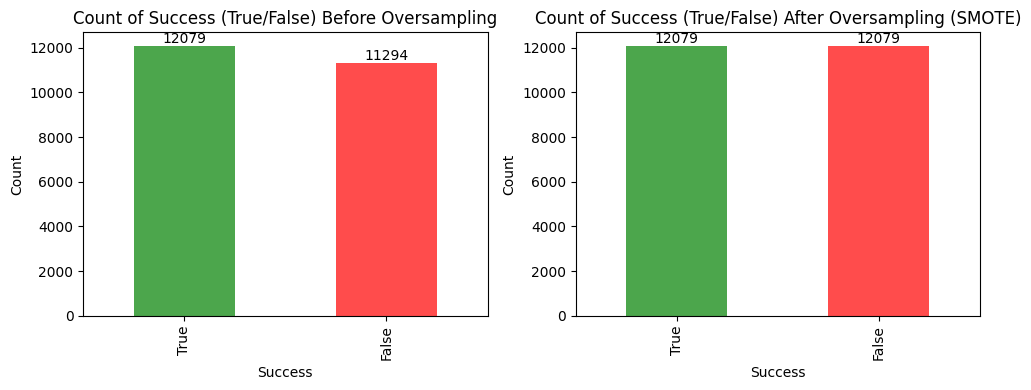

In [15]:

smote = SMOTE(sampling_strategy='minority')
X_resampled, y_resampled = smote.fit_resample(X, y)

# Count the values in the 'success' column after oversampling
success_counts_resampled = pd.Series(Counter(y_resampled))

# Create a bar chart to compare counts before and after oversampling
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
success_counts.plot(kind='bar', color=['green', 'red'], alpha=0.7)
plt.title('Count of Success (True/False) Before Oversampling')
plt.xlabel('Success')
plt.ylabel('Count')
for index, value in enumerate(success_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.subplot(1, 2, 2)
success_counts_resampled.plot(kind='bar', color=['green', 'red'], alpha=0.7)
plt.title('Count of Success (True/False) After Oversampling (SMOTE)')
plt.xlabel('Success')
plt.ylabel('Count')
for index, value in enumerate(success_counts_resampled):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [16]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.75, stratify=y_resampled)


In [17]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [18]:
len(X.columns)

396

In [19]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len( X_train_scaled[0])
hidden_nodes_layer1=400
hidden_nodes_layer2=150
hidden_nodes_layer3=5


nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation='tanh'))


# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation='tanh'))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation='tanh'))


# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))


# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 400)               158800    
                                                                 
 dense_1 (Dense)             (None, 150)               60150     
                                                                 
 dense_2 (Dense)             (None, 5)                 755       
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 219711 (858.25 KB)
Trainable params: 219711 (858.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# Compile the model
opt = keras.optimizers.Adam(learning_rate=0.01)
nn.compile(loss = 'binary_crossentropy', optimizer = opt, metrics=['accuracy'])

In [21]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,validation_split=0.15, epochs=50, batch_size = 50)

Epoch 1/50
103/103 [==============================] - 3s 15ms/step - loss: 0.6541 - accuracy: 0.6283 - val_loss: 0.6426 - val_accuracy: 0.6402
Epoch 2/50
103/103 [==============================] - 1s 14ms/step - loss: 0.6124 - accuracy: 0.6643 - val_loss: 0.6064 - val_accuracy: 0.6457
Epoch 3/50
103/103 [==============================] - 1s 11ms/step - loss: 0.5865 - accuracy: 0.6667 - val_loss: 0.6105 - val_accuracy: 0.6225
Epoch 4/50
103/103 [==============================] - 1s 9ms/step - loss: 0.5721 - accuracy: 0.6842 - val_loss: 0.6117 - val_accuracy: 0.6623
Epoch 5/50
103/103 [==============================] - 1s 7ms/step - loss: 0.5547 - accuracy: 0.7008 - val_loss: 0.5949 - val_accuracy: 0.6689
Epoch 6/50
103/103 [==============================] - 1s 9ms/step - loss: 0.5488 - accuracy: 0.7010 - val_loss: 0.6016 - val_accuracy: 0.6512
Epoch 7/50
103/103 [==============================] - 1s 9ms/step - loss: 0.5493 - accuracy: 0.6973 - val_loss: 0.6349 - val_accuracy: 0.6634
Epo

In [22]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")


567/567 - 2s - loss: 0.5863 - accuracy: 0.6863 - 2s/epoch - 3ms/step
Loss: 0.5863198637962341, Accuracy: 0.6862961649894714
